# Extending Catalogue Data

In this tutorial, we take a catalogue of asteroid data and extend it using the `astroquery` and `rocks` packages.
This is a common task when working with archival data and we will see frequently-occurring issues and how to solve them.

The catalogue we will be working with is the first version of the *Moving Objects Catalog* (MOC1) of the SDSS survey.

In [1]:
import time

from astroquery.mpc import MPC
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rocks
from tqdm import tqdm  # for progress bars

First task: Acquire the catalogue. We can download it and read it from file (do
this if you expect to use it frequently), but for the purpose of demonstration,
we use a nice feature of the `pandas` package: Most data-ingestion functions
like `read_csv`, `read_json`, `read_fwf` (fixed-width format) accept URLs
pointing to files. Here, we point to a `gzip` compressed version of the
catalogue and provide `pandas` with some metadata to parse the data it is
downloading. We don't need all the information, we only get the number,
designation, and the ugriz magnitudes from the catalogue.

In [2]:
data = pd.read_fwf(
    "https://faculty.washington.edu/ivezic/sdssmoc/ADR1.dat.gz",
    colspecs=[(244, 250), (250, 270), (163, 168), (174, 179), (185, 190), (196, 201), (207, 212)],
    names=["numeration", "designation", 'u', 'g', 'r', 'i', 'z'],
    compression='gzip'
)

print(f"Number of observations in SDSS MOC1: {len(data)}")
data.head()

Number of observations in SDSS MOC1: 58117


,numeration,designation,u,g,r,i,z
0,0,-,22.70,20.56,20.00,19.83,19.95
1,0,1999_RL189,21.41,19.88,19.22,18.92,19.01
2,0,-,22.54,21.34,20.49,20.21,20.49
3,11659,1997_EX41,19.86,18.30,17.81,17.70,17.70
4,0,-,22.48,21.34,20.74,20.68,20.23


We note that there are asteroids with `numeration = 0` and `designation = '-'`. The [documentation](http://faculty.washington.edu/ivezic/sdssmoc/sdssmoc1.html) of this catalogue
states that only 12,602 of the 58,117 entries could be associated to 10,592 unique objects known at the time. The rest are included as unidentified objects. We could likely identify
the vast majority now using a tool like [SkyBoT](https://ssp.imcce.fr/webservices/skybot/) to check the SDSS field-of-views for asteroids known today (using the code we wrote on Tuesday for instance), but this is not the purpose of this tutorial (and it has
been done already, [Sergeyev & Carry 2021](https://ui.adsabs.harvard.edu/abs/2021A&A...652A..59S/abstract)).

Instead, we drop all entries belonging to unknown asteroids here. We further set the number of unnumbered asteroids to `NaN` instead
of the commonly used (but aesthetically questionable) `0`.

In [3]:
# Remove the unknown objects
data = data[data.designation.str.strip(" ") != "-"]
print(f"Observations of known objects: {len(set(data.designation))}")

# Unnumbered objects should be NaN
data.loc[data.numeration == 0, "numeration"] = np.nan

data.describe()

Observations of known objects: 10585


,numeration,u,g,r,i,z
count,3271.000000,12600.000000,12600.000000,12600.000000,12600.000000,12600.000000
mean,17464.664934,21.031693,19.406415,18.782208,18.612157,18.646316
std,9235.033631,1.125182,1.796740,1.077645,1.656807,2.083118
min,220.000000,16.480000,14.940000,14.520000,14.280000,14.250000
25%,9585.000000,20.380000,18.760000,18.160000,17.970000,17.980000
50%,17288.000000,21.080000,19.460000,18.860000,18.680000,18.690000
75%,25937.000000,21.730000,20.100000,19.510000,19.320000,19.330000
max,32729.000000,28.950000,99.990000,21.490000,99.990000,99.990000


Looking good so far. Since the catalogue came out over 20 years ago, we can expect a large fraction of theses asteroids to now have been numbered
and even named. We thus add two columns, `name` and `number`. We query the current name and number using the `rocks.identify` function,
which accepts a list of identifiers (like designations, numbers, names) and returns a list of tuples containing the name and number of the identified
objects. We create the list of identifiers by combining the `numeration` and the `designation` columns.

In [4]:
# Create list of identifiers by merging 'numeration' and 'designation' columns
ids = data.numeration.fillna(data.designation)
print("Identifying known objects in catalogue..")
names_numbers = rocks.identify(ids)

Identifying known objects in catalogue..


The names and numbers are returned in the order of the passed identifiers. We can add them to the SDSS data using a simple list comprehension.

In [5]:
# Add numbers and names to data
data["name"] = [name_number[0] for name_number in names_numbers]
data["number"] = [name_number[1] for name_number in names_numbers]

# Print part of the result
data.number = data.number.astype("Int64")  # Int64 supports integers and NaN
data.head()

,numeration,designation,u,g,r,i,z,name,number
1,NaN,1999_RL189,21.41,19.88,19.22,18.92,19.01,1999 RL189,159415
3,11659.0,1997_EX41,19.86,18.30,17.81,17.70,17.70,1997 EX41,11659
7,3633.0,Mira,19.27,17.69,17.18,16.98,16.96,Mira,3633
8,NaN,2765_P-L,20.70,19.23,18.75,18.61,18.54,2765 P-L,39383
9,NaN,2000_SR274,21.51,19.64,19.11,18.92,18.86,2000 SR274,62569


Great, this worked as expected.
We set the datatype of the `number` columns to the `Int64` type as this type can deal with integers and `NaN` values.
This is a useful little trick when working with the `number` column.

Now that we know what asteroids we are working with, let's have a look at their colours.

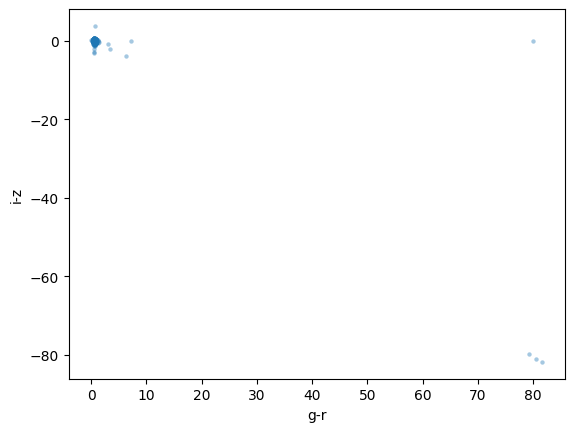

In [6]:
fig, ax = plt.subplots()

ax.scatter(data["g"] - data["r"], data["i"] - data["z"], alpha=0.4, s=10, lw=0)
ax.set(xlabel="g-r", ylabel="i-z");

We have some outliers that we remove generously.

In [7]:
data = data[(data['g']-data['r']) < 2]
data = data[(data['g']-data['r']) > -2]
data = data[(data['i']-data['z']) < 2]
data = data[(data['i']-data['z']) > -2]

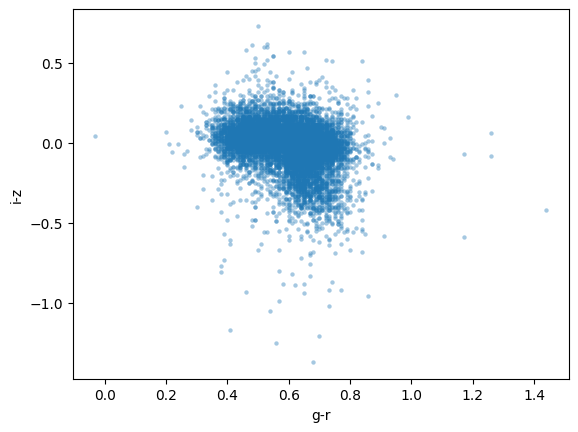

In [8]:
fig, ax = plt.subplots()

ax.scatter(data["g"] - data["r"], data["i"] - data["z"], alpha=0.4, s=10, lw=0)
ax.set(xlabel="g-r", ylabel="i-z");

Now it looks as we expected it. Next, we add some additional information to this plot.
For each object, we query the albedo and the taxonomical complex from SsODNet using `rocks` and
the $\Delta$V from the MPC. `rocks` uses asynchronous queries, meaning that it will process multiple
queries at the same time, while the `astroquery` code uses synchronous code, meaning that the queries are processed
one after the other. We will see this difference in the execution time.

For the `MPC` query, we have to specify whether we query the object by name,
number, or designation. To simplify, we reduce the dataset to numbered
asteroids and only take 100 entries in the catalogue for the sake of brevity.
And for the sake of a fair comparison, we turn off the cache usage of `rocks`,
which would typically prevent repeated queries to the server in favour of local
copies of the data.

In [9]:
data = data[~pd.isna(data.number)]
data = data[:100]
rocks.CACHELESS = True

start_time = time.time()
targets = rocks.rocks(data['name'])

for target in targets:
  data.loc[data['name'] == target.name, 'complex'] = target.taxonomy.complex.value
  data.loc[data['name'] == target.name, 'albedo'] = target.albedo.value
print(f"rocks took {time.time() - start_time:.2f} seconds.")

rocks took 7.20 seconds.


For the `astroquery.MPC` module, we cannot disable caching, so only the first run of this block
will give a representative result.

In [10]:
start_time = time.time()
for ind, d in data.iterrows():
  target = MPC.query_object('asteroid', number=d['number'])
  data.loc[ind, 'delta_v'] = target[0]['delta_v']
print(f"astroquery took {time.time() - start_time:.2f} seconds.")

astroquery took 21.73 seconds.


`rocks` is about 5-6 times faster due to the asynchronous query logic.

Since we removed a lot of data points to assess the different execution times, the plots
are less impressive than before.

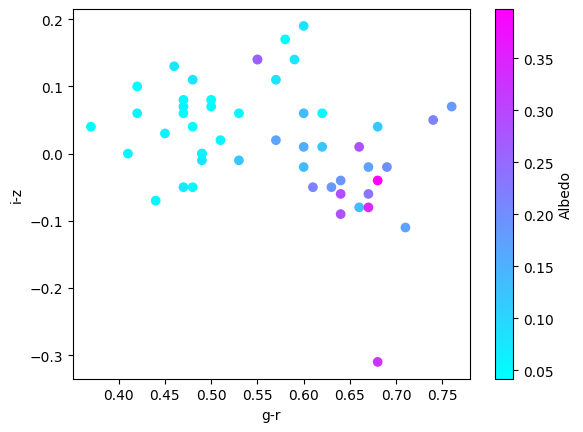

In [11]:
fig, ax = plt.subplots()

scat = ax.scatter(data["g"] - data["r"], data["i"] - data["z"], c=data['albedo'], cmap='cool')
ax.set(xlabel="g-r", ylabel="i-z")
fig.colorbar(scat, label='Albedo');

In practice, there is no issue working with tens/hundreds of thousands of data points like this, as both
packages apply caching which significantly reduces the execution times on repeated runs.